# Embeddings

only possible on some models (e.g. ada)
https://platform.openai.com/docs/guides/embeddings/what-are-embeddings.


I'll use the second generation model ``text-embedding-ada-002`` (cl100k_base) with max. 8191 input tokens and 1536 output dimensions.

Costwise it should roughly do 3000 pages per dollar. ($0.0004 / 1K tokens). With ["getting-started-with-mikeio"](https://dhi.github.io/getting-started-with-mikeio/intro.html) it should be around 19000 tokens so $0.0076 (19000/1000*0.0004)


In [12]:
import openai
import os
import pandas as pd


In [5]:
openai.api_key = os.getenv("OPENAI_API_KEY")

### gather data

**crawl url**

In [7]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "github.com/clemenscremer/" # <- put your domain to be crawled
full_url = "https://github.com/clemenscremer/making_friends_with_quarto/tree/main" # <- put your domain to be crawled with https or http, Hyperlinks on this subdomain will also be crawled

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])
            
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))
    
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

In [ ]:
crawl(full_url)

**crawl local folder** (containing python, markdown and jupyter notebooks)

In [ ]:
import os
import json

def extract_text_from_md(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

def extract_text_from_ipynb(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    text = []
    for cell in data["cells"]:
        if cell["cell_type"] in ["code", "markdown"]:
            text.extend(cell["source"])

    return "\n".join(text)

def extract_text_from_py(file_path):
    with open(file_path, "r", encoding="utf-8") as f:
        return f.read()

def extract_text_from_files(folder_path):
    extracted_texts = {}

    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            file_ext = os.path.splitext(file)[-1]

            if file_ext == ".md":
                extracted_texts[file] = extract_text_from_md(file_path)
            elif file_ext == ".ipynb":
                extracted_texts[file] = extract_text_from_ipynb(file_path)
            elif file_ext == ".py":
                extracted_texts[file] = extract_text_from_py(file_path)

    return extracted_texts




folder_path = "../raw_input/gsw_mikeio"  # Replace this with the path to your folder
extracted_texts = extract_text_from_files(folder_path)



# save extracted text to files
def save_extracted_text_to_file(file_name, text):
    output_file_name = os.path.splitext(file_name)[0] + ".txt"
    with open(output_file_name, "w", encoding="utf-8") as f:
        f.write(text)
        
for file_name, text in extracted_texts.items():
    save_extracted_text_to_file(file_name, text)
    

### Build embeddings index

from files stored in subfolder /text

<div class="alert alert-block alert-info">
<b>Tip:</b> "Blank empty lines can clutter the text files and make them harder to process. A simple function can remove those lines and tidy up the files."
</div>

In [15]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie



# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/"):

    # Open the file and read the text
    with open("text/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

C:\Users\clcr\AppData\Local\Temp\ipykernel_30456\1367190806.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,,. # Basic Python Python is a high level genera...
1,res,res. # Data Structures MIKE IO has these prima...
2,medelta,medelta. # Datetimes and timedeltas Python has...
3,,. # Dfs0 See [Dfs0 in MIKE IO Documentation](h...
4,,. # Dfs1 Dfs1 has in addition to the dfs0 file...


### tokenize

<div class="alert alert-block alert-info">
<b>Note:</b>
The API has a limit on the maximum number of input tokens for embeddings. To stay below the limit, the text in the CSV file needs to be broken down into multiple rows. The existing length of each row will be recorded first to identify which rows need to be split.
</div>

In [ ]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

total number of tokens 18267


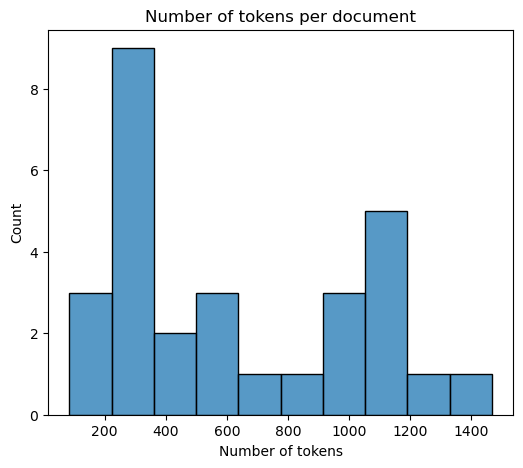

In [39]:
import seaborn as sns
# do histplot with seaborn (max tokens are 8191 for 2nd generation ada model, if we exceed this we would need to split)
fig, ax = plt.subplots(figsize=(6, 5))	
sns.histplot(df.n_tokens, bins=10, ax=ax);
ax.set_xlabel('Number of tokens')
ax.set_ylabel=('Number of documents')	
ax.set_title('Number of tokens per document')

print(f"total number of tokens {df.n_tokens.sum()}")

#### if needed: split into smaller chunks (<8191 tokens)
 

In [ ]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

### send preprocessed data to openAI for processing ($$$)

In [37]:
import openai
engine = 'text-embedding-ada-002'
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, 
                                                                   engine=engine)['data'][0]['embedding'])

df.to_csv('processed/embeddings.csv')
df.head()

,title,text,n_tokens,embeddings
0,NaN,. # Basic Python Python is a high level genera...,1122,"[-0.00912307295948267, 0.014363128691911697, 0..."
1,res,res. # Data Structures MIKE IO has these prima...,245,"[-0.0007991945021785796, 0.0036900753621011972..."
2,medelta,medelta. # Datetimes and timedeltas Python has...,1052,"[0.0020638047717511654, -0.006340141873806715,..."
3,NaN,. # Dfs0 See [Dfs0 in MIKE IO Documentation](h...,1065,"[-0.004047850612550974, 0.004773047287017107, ..."
4,NaN,. # Dfs1 Dfs1 has in addition to the dfs0 file...,593,"[0.001346861943602562, 0.026005946099758148, -..."


### Visualize embeddings

higher dimensional visualization with t-SNE explored here: https://platform.openai.com/docs/guides/embeddings/use-cases

### > Ask questions based on the embedded data


#### further processing of embeddings data

In [2]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
# convert embeddings to 1D numpy array makes it easier to work with later
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,title,text,n_tokens,embeddings
0,NaN,. # Basic Python Python is a high level genera...,1122,"[-0.00912307295948267, 0.014363128691911697, 0..."
1,res,res. # Data Structures MIKE IO has these prima...,245,"[-0.0007991945021785796, 0.0036900753621011972..."
2,medelta,medelta. # Datetimes and timedeltas Python has...,1052,"[0.0020638047717511654, -0.006340141873806715,..."
3,NaN,. # Dfs0 See [Dfs0 in MIKE IO Documentation](h...,1065,"[-0.004047850612550974, 0.004773047287017107, ..."
4,NaN,. # Dfs1 Dfs1 has in addition to the dfs0 file...,593,"[0.001346861943602562, 0.026005946099758148, -..."


#### Translate NL question to embedding and compute distance between embeddings of question and content

- The question needs to be converted to an embedding. 
- The search with embeddings compares the vector of numbers (which was the conversion of the raw text) using cosine distance. 
- The vectors are likely related and might be the answer to the question if they are close in cosine distance.
- The **result is solely semantically related/close to the question**. But there is no guarantee that this proximity is actually the answer to the question.

In [67]:
def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine=engine)['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

#### Answer question

here we can use other models than for embeddings (e.g. text-davinci-003)

In [79]:
completion_model = "text-davinci-003" # needs to be completion (single-turn) model (ada, babbage, curie or davinci) and not chat model 

def answer_question(
    df,
    model=completion_model,
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

In [69]:
answer_question(df, question="Why should you use MIKE IO")#, debug=True)

'You should use MIKE IO if you use Python for programming or data analysis and you are a MIKE modeler with knowledge of the Python libraries NumPy and Pandas.'

In [70]:
answer_question(df, question="Can you create animations with MIKE IO?")#, debug=True)

"I don't know."

In [72]:
answer_question(df, question="How do i test if i properly installed MIKE IO?")#, debug=True)

'Run the following lines of code: ```python import mikeio print("MIKE IO: " + mikeio.__version__) ```'

In [74]:
answer_question(df, question="Can i interpolate 2D dfsu data to a raster? If so, how?")#, debug=True)

'Yes, you can interpolate 2D dfsu data to a raster. To do this, you can use the interp() method on the DataArray object. For example, you can use the following code to interpolate the elevation data to a specific location: da_stn = elevation.interp(x=stn[0], y=stn[1])'

# Findings


- embeddings [computerphile](https://www.youtube.com/watch?v=gQddtTdmG_8), [Udacity cats and kittys](https://www.youtube.com/watch?v=186HUTBQnpY), [Udacity cats and encoding](https://www.youtube.com/watch?v=BD8wPsr_DAI), [Sung version incl. sequence prediction](https://www.youtube.com/watch?v=viZrOnJclY0): 
    - instead of words (or part of it) represented by a number, a whole sentence or document is represented by a vector of numbers (embedding)
    - NNs don't work well with words, but with numbers
    - capacity of auto(regressive) approaches is limeted, so this representation is saving memory for the neural net (maybe too simply: one number instead of a whole word).
        - instead of the neural net having to learn which characters compose valid words, the vector representation of the word is learned instead
    - text to float vector 
    - float vector has 1536 dimensions (currently for openai models)
    - can to some extent be imagined and translated to 2d or 3d space (e.g. t-SNE) "How are tokens related to each other in the embedding space?" 
    - steps:
        - generate embedding for **query** (question)
        - perform **similarity search between query and embeddings** (database) of content (e.g. euclidean distance cosine, dot product)
        - note: openai embeddings are normalized (hence cosine similarity and dot product are equivalent)
        - **hand context to model to answer question**
        - note: **context** is the part of the embeddings that is relevant (acc. to similarity search) for the question
    - in summary, **embeddings** rely on a database that **can be easily updated** (as opposed to model fine-tuning or retraining) 
    
- retraining:
    - new numbers are assigned to each word and distances between all are newly determined
------
- learnings

    - great to build a personal assistant instead of a wiki
    - splitting in smaller chucnks could also reduce context needed to be handed over for each query (better focus on relevant part of text)
    - queries show high token number (~4k for simple question). This is most likely due to the fact that context (part of embeddings dataframe) needs to be handed over to the model as well.
    - <mark> Currently, the dataframe is being passed in each time to answer a question. For more production workflows, a vector database solution should be used instead of storing the embeddings in a CSV file, but the current approach is a great option for prototyping.
    - A longer but more precise prompt seems to drive the number of tokens handed to openai down, probably by preconditioning the search space (context gets narrower and df doesn't have to be handed over entirely).
    - Microsoft seems to provide a vector database solution "The alternative is to keep all the data in an external knowledge base that can **retrieve pieces quickly and with good relevance**, exactly what Cognitive Search was designed for."[MS blog](https://techcommunity.microsoft.com/t5/ai-applied-ai-blog/revolutionize-your-enterprise-data-with-chatgpt-next-gen-apps-w/ba-p/3762087)
    - https://github.com/openai/openai-cookbook/tree/main/examples/vector_databases

    ## Potential vector database solutions
    - Pinecone, a fully managed vector database
    - Weaviate, an open-source vector search engine
    - Redis as a vector database
    - Qdrant, a vector search engine
    - Milvus, a vector database built for scalable similarity search
    - Chroma, an open-source embeddings store